In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_comparative_histograms(dfs_list, names, titles, metric, dataset, age=True):
    # Set the theme for seaborn plots
    sns.set_theme(style='darkgrid')

    # Create the subplot grid
    
    shape = len(dfs_list) + 1 * age
    fig, axes = plt.subplots(1, shape, figsize=(8 * shape, 8))
    fig.tight_layout(pad=5)

    # Create a color palette for the labels
    palette = sns.color_palette()

    # Iterate through the datasets and plot the histograms
    for i, (dfs, name, title) in enumerate(zip(dfs_list, names, titles)):
        # Select the axes for the subplot
        if shape == 1:
            ax = axes
        else:
            ax = axes[i]

        # Set the title and axis labels
        if "Max" in metric:
            ax.set_title("RCA-estimated DSC Histogram (Max) for " + title, fontsize=18)
        else:
            ax.set_title("RCA-estimated DSC Histogram for " + title, fontsize=18)

        ax.set_xlabel("RCA-estimated DSC", fontsize=16)
        ax.set_ylabel('Percentage', fontsize=16)
        ax.set_xlim([0.65, 1.0])

        # Plot histograms for each dataframe in the pair
        for j, df in enumerate(dfs):
            values = df[metric]
            bins = np.linspace(0.65, 1.0, 20)
            sns.histplot(data=values, kde=True, bins=bins, ax=ax, stat='density', alpha=0.5, label=name[j], color=palette[j])

        # Add a legend to distinguish the histograms in the pair
        ax.legend()

    # Add a title for the entire figure
    if shape == 1:    
        if "Max" in metric:
            plt.suptitle("RCA-estimated DSC Histogram (Max) for %s" % dataset, fontsize=22)
        else:
            plt.suptitle("RCA-estimated DSC Histogram for %s" % dataset, fontsize=22)
    else:
        if "Max" in metric:
            plt.suptitle("RCA-estimated DSC Histograms (Max) for %s" % dataset, fontsize=22)
        else:
            plt.suptitle("RCA-estimated DSC Histograms for %s" % dataset, fontsize=22)

    return fig, axes

In [2]:
import pandas as pd 

metadata = "ChestX-ray8/Data_Entry_2017.csv"
df = pd.read_csv(metadata)

# Remove last column
df = df.iloc[:, :-1]

rca_path = "../RCA/ChestX-ray8.csv"
rca_df = pd.read_csv(rca_path)

# Join them on the Image index
combined_df = df.join(rca_df.set_index('Image Index'), on='Image Index')

In [3]:
combined_df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Dice RCA (Mean)',
       'Dice RCA (Max)'],
      dtype='object')

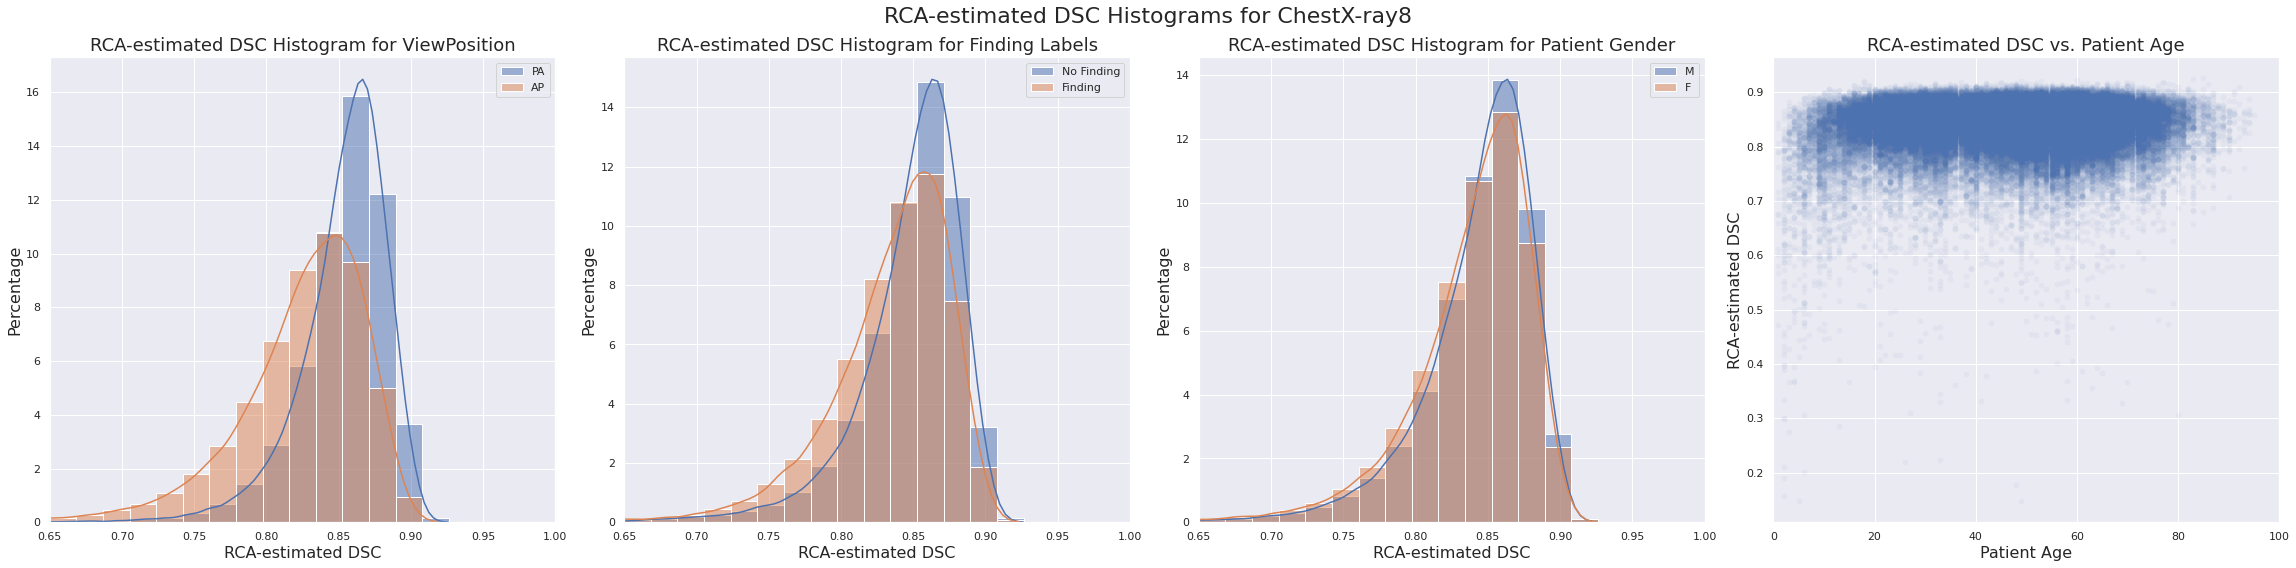

In [4]:
# Create different subsets, first by view position

sub1 = combined_df[combined_df['View Position'] == 'PA']
sub2 = combined_df[combined_df['View Position'] == 'AP']
name1 = "PA"
name2 = "AP"

# Now by "Finding Labels" 
sub3 = combined_df[combined_df['Finding Labels'] == 'No Finding']
sub4 = combined_df[combined_df['Finding Labels'] != 'No Finding']
name3 = "No Finding"
name4 = "Finding"

# Now by Patient Gender
sub5 = combined_df[combined_df['Patient Gender'] == 'M']
sub6 = combined_df[combined_df['Patient Gender'] == 'F']
name5 = "M"
name6 = "F"

fig, axes = plot_comparative_histograms([[sub1, sub2], [sub3, sub4], [sub5, sub6]], 
                                        [[name1, name2], [name3, name4], [name5, name6]], 
                                        ["ViewPosition", "Finding Labels", "Patient Gender"],
                                        "Dice RCA (Mean)",
                                        "ChestX-ray8")

ax = axes[3]

# remove border from the scatterplot
sns.scatterplot(data=combined_df, x="Patient Age", y="Dice RCA (Mean)", ax=ax, alpha=0.05, linewidth=0)
ax.set_title("RCA-estimated DSC vs. Patient Age", fontsize=18)
ax.set_xlabel("Patient Age", fontsize=16)
ax.set_ylabel("RCA-estimated DSC", fontsize=16)
ax.set_xlim([0, 100])

plt.tight_layout()
plt.savefig("ChestX-ray8.png", dpi=300)

In [5]:
import pandas as pd 

metadata1 = "CheXpert/train.csv"
df = pd.read_csv(metadata1)
metadata2 = "CheXpert/valid.csv"
df = df.append(pd.read_csv(metadata2), ignore_index=True)

rca_path = "../RCA/CheXpert.csv"
rca_df = pd.read_csv(rca_path)

# Add CheXpert-v1.0/ to each path
rca_df.Path = rca_df.Path.apply(lambda x: "CheXpert-v1.0/" + x)

combined_df = df.join(rca_df.set_index('Path'), on='Path')

# remove rows with NaN in the RCA columns

combined_df = combined_df.dropna(subset=['Dice RCA (Mean)'])

/tmp/ipykernel_21006/2361157603.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(metadata2), ignore_index=True)


In [6]:
# Finding list 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
# 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
# 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture'

# Merge all the Findings into one column

findings = ['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
            'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
            'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture']

# merge as a boolean

findings_df = combined_df[findings]
findings_df = findings_df.fillna(0)
findings_df = findings_df.astype(bool)
findings_df = findings_df.any(axis=1)

combined_df['Finding'] = findings_df


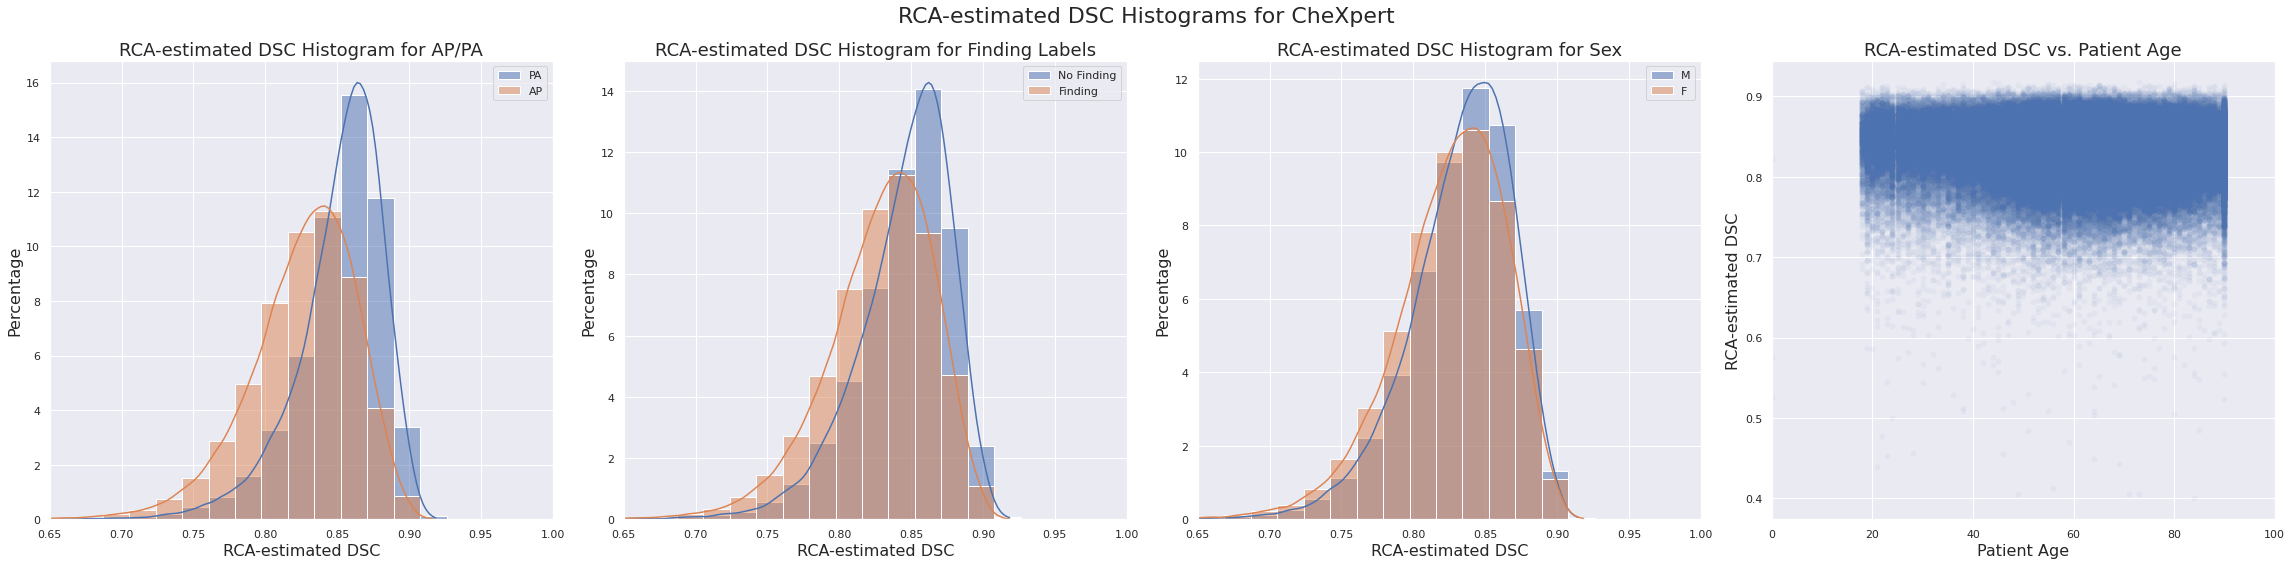

In [7]:
# Create different subsets, first by view position

sub1 = combined_df[combined_df['AP/PA'] == 'PA']
sub2 = combined_df[combined_df['AP/PA'] == 'AP']
name1 = "PA"
name2 = "AP"

# Now by "Finding Labels" 
sub3 = combined_df[combined_df['Finding'] != True]
sub4 = combined_df[combined_df['Finding'] == True]
name3 = "No Finding"
name4 = "Finding"

# Now by Patient Gender
sub5 = combined_df[combined_df['Sex'] == 'Male']
sub6 = combined_df[combined_df['Sex'] == 'Female']
name5 = "M"
name6 = "F"

fig, axes = plot_comparative_histograms([[sub1, sub2], [sub3, sub4], [sub5, sub6]], 
                                        [[name1, name2], [name3, name4], [name5, name6]], 
                                        ["AP/PA", "Finding Labels", "Sex"],
                                        "Dice RCA (Mean)",
                                        "CheXpert")

ax = axes[3]

sns.scatterplot(data=combined_df, x="Age", y="Dice RCA (Mean)", ax=ax, alpha = 0.05, linewidth=0)
ax.set_title("RCA-estimated DSC vs. Patient Age", fontsize=18)
ax.set_xlabel("Patient Age", fontsize=16)
ax.set_ylabel("RCA-estimated DSC", fontsize=16)
ax.set_xlim([0, 100])

plt.tight_layout()
plt.savefig("CheXpert.png", dpi=300)

In [8]:
import pandas as pd 

metadata1 = "MIMIC-CXR-JPG/mimic-cxr-2.0.0-metadata.csv.gz"
df = pd.read_csv(metadata1)[['dicom_id', 'ViewPosition']]

rca_df = pd.read_csv("../RCA/MIMIC-CXR-JPG.csv")

combined_df = df.join(rca_df.set_index('dicom_id'), on='dicom_id')

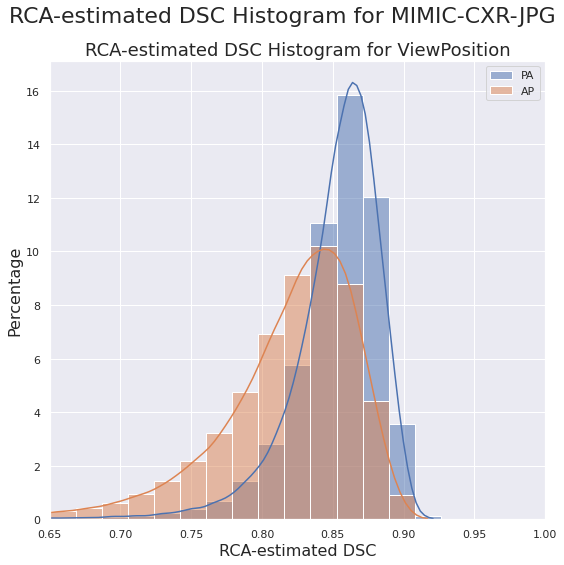

In [9]:
# Create different subsets, first by view position

sub1 = combined_df[combined_df['ViewPosition'] == 'PA']
sub2 = combined_df[combined_df['ViewPosition'] == 'AP']
name1 = "PA"
name2 = "AP"

fig, axes = plot_comparative_histograms([[sub1, sub2]], 
                                        [[name1, name2]], 
                                        ["ViewPosition"],
                                        "Dice RCA (Mean)",
                                        "MIMIC-CXR-JPG", False)


plt.tight_layout()
plt.savefig("MIMIC-CXR-JPG.png", dpi=300)

In [10]:
metadata = "Padchest/PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv.gz" 
df = pd.read_csv(metadata)[['ImageID', 'PatientSex_DICOM', 'Projection', 'Labels']]

# if label is ['normal'], findings is 0, else 1

df["Findings"] = df.Labels.apply(lambda x: 0 if x == "['normal']" else 1)

rca_df = pd.read_csv("../RCA/Padchest.csv")

combined_df = df.join(rca_df.set_index('ImageID'), on='ImageID')

# drop rows with NaN in the RCA columns
combined_df = combined_df.dropna(subset=['Dice RCA (Mean)'])

/tmp/ipykernel_21006/239407473.py:2: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(metadata)[['ImageID', 'PatientSex_DICOM', 'Projection', 'Labels']]
/tmp/ipykernel_21006/239407473.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Findings"] = df.Labels.apply(lambda x: 0 if x == "['normal']" else 1)


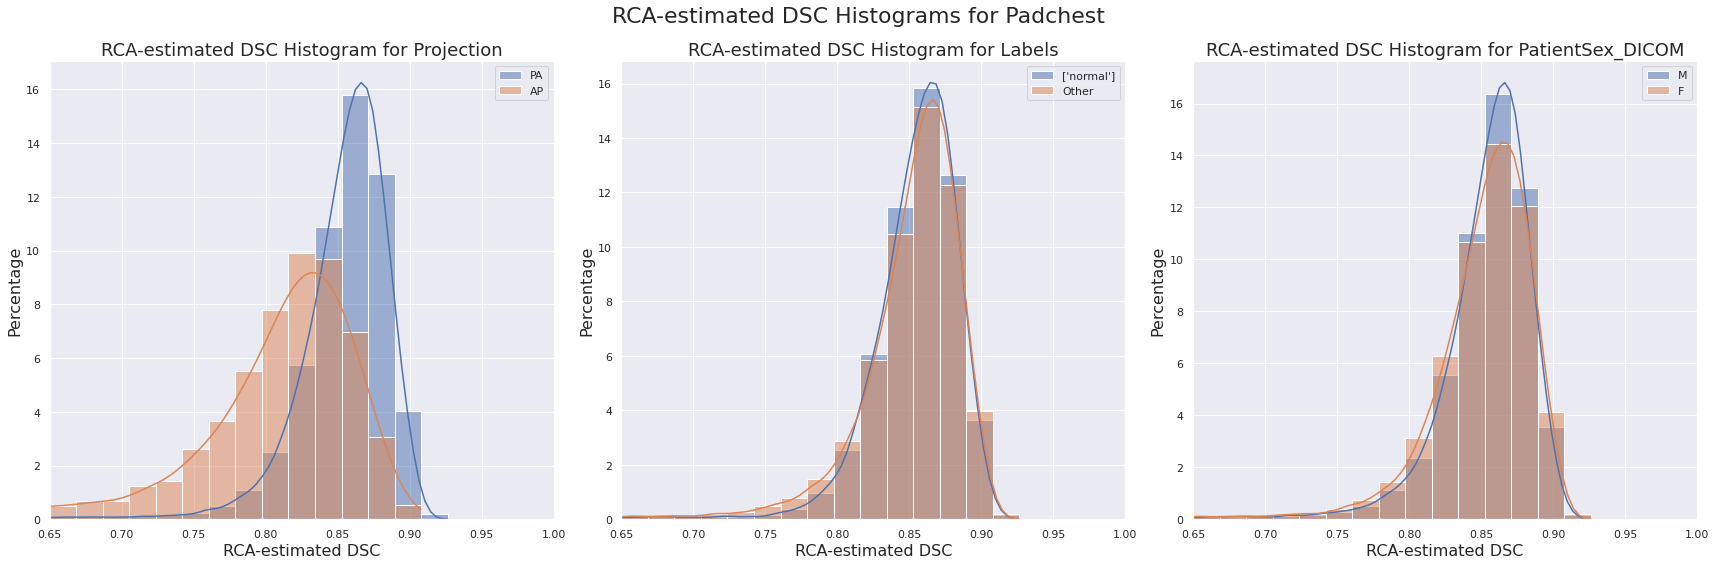

In [11]:
# Create different subsets, first by view position

sub1 = combined_df[combined_df['Projection'] == 'PA']
sub2 = combined_df[combined_df['Projection'] == 'AP']
name1 = "PA"
name2 = "AP"

sub3 = combined_df[combined_df['Findings'] == 0]
sub4 = combined_df[combined_df['Findings'] == 1]
name3 = "['normal']"
name4 = "Other"

sub5 = combined_df[combined_df['PatientSex_DICOM'] == 'M']
sub6 = combined_df[combined_df['PatientSex_DICOM'] == 'F']
name5 = "M"
name6 = "F"

fig, axes = plot_comparative_histograms([[sub1, sub2], [sub3, sub4], [sub5, sub6]],
                                        [[name1, name2], [name3, name4], [name5, name6]], 
                                        ["Projection", "Labels", "PatientSex_DICOM"],
                                        "Dice RCA (Mean)",
                                        "Padchest", False)


plt.tight_layout()
plt.savefig("Padchest.png", dpi=300)